In [2]:
# Imports

import numpy as np
import pandas as pd

import matplotlib.pylab as plt
%matplotlib inline
import seaborn as sns

import math
import duckdb
from scipy.stats import trim_mean

### Create Dataset Connection

In [3]:
db_connect = duckdb.connect('./dataset/diamonds_train.db')

### Reading Tables and creating DataFrames

In [4]:
# I create a function to read every table of the DB.

tables = ['diamonds_city', 'diamonds_clarity', 'diamonds_color', 'diamonds_cut',\
          'diamonds_dimensions', 'diamonds_properties', 'diamonds_transactional']

dfs = {}
for name in tables:
    query = f'SELECT * FROM {name}'
    df = db_connect.execute(query).fetchdf()
    dfs[name] = df

In [5]:
# Reading and creating Dataframes

diamonds_city = dfs['diamonds_city']
diamonds_clarity = dfs['diamonds_clarity']
diamonds_color = dfs['diamonds_color']
diamonds_cut = dfs['diamonds_cut']
diamonds_dimensions = dfs['diamonds_dimensions']
diamonds_properties = dfs['diamonds_properties']
diamonds_transactional = dfs['diamonds_transactional']

In [6]:
# Joining all dataframes

df1 = diamonds_transactional.merge(diamonds_city, on='city_id')
diamonds_df = df1.join(diamonds_properties.set_index('index_id'), on='index_id')\
          .join(diamonds_color.set_index('color_id'), on='color_id')\
          .join(diamonds_cut.set_index('cut_id'), on='cut_id')\
          .join(diamonds_clarity.set_index('clarity_id'), on='clarity_id')\
          .join(diamonds_dimensions.set_index('index_id'), on='index_id')

### Making some transformations

In [7]:
# Datafram Info

diamonds_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40455 entries, 0 to 40454
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   index_id    40455 non-null  object 
 1   price       40455 non-null  int64  
 2   city_id     40455 non-null  object 
 3   carat       40455 non-null  float64
 4   city        40455 non-null  object 
 5   cut_id      40455 non-null  object 
 6   color_id    40455 non-null  object 
 7   clarity_id  40455 non-null  object 
 8   color       40455 non-null  object 
 9   cut         40455 non-null  object 
 10  clarity     40455 non-null  object 
 11  depth       40455 non-null  float64
 12  table       40455 non-null  float64
 13  x           40455 non-null  float64
 14  y           40455 non-null  float64
 15  z           40455 non-null  float64
dtypes: float64(6), int64(1), object(9)
memory usage: 5.2+ MB


In [8]:
# Droping some columns

columns = ['index_id','city_id','cut_id','color_id','clarity_id']
diamonds_df.drop(columns, inplace=True, axis=1)

In [9]:
# Looking uniques values

city = diamonds_df['city'].unique()
color = diamonds_df['color'].unique()
cut = diamonds_df['cut'].unique()
clarity = diamonds_df['clarity'].unique()

print(f'Cities: ({len(city)}) - {city}')
print(f'\nColors: ({len(color)}) - {color}')
print(f'Cut: ({len(cut)}) - {cut}')
print(f'Clarity: ({len(clarity)}) - {clarity}')

Cities: (13) - ['Dubai' 'Kimberly' 'Las Vegas' 'Tel Aviv' 'Amsterdam' 'Zurich' 'Antwerp'
 'Madrid' 'Paris' 'Surat' 'Luxembourg' 'London' 'New York City']

Colors: (7) - ['J' 'G' 'I' 'E' 'D' 'F' 'H']
Cut: (5) - ['Premium' 'Ideal' 'Good' 'Very Good' 'Fair']
Clarity: (8) - ['VS2' 'SI1' 'SI2' 'IF' 'VS1' 'VVS2' 'VVS1' 'I1']


In [10]:
# Final Dataframe:

diamonds_df

,price,carat,city,color,cut,clarity,depth,table,x,y,z
0,4268,1.21,Dubai,J,Premium,VS2,62.4,58.0,6.83,6.79,4.25
1,4882,1.02,Dubai,G,Ideal,SI1,60.5,59.0,6.55,6.51,3.95
2,14208,2.00,Dubai,I,Premium,SI2,61.3,59.0,8.13,8.09,4.97
3,5113,1.01,Dubai,G,Good,SI1,63.7,60.0,6.32,6.28,4.01
4,2898,0.79,Dubai,G,Ideal,SI1,62.3,57.0,5.90,5.85,3.66
...,...,...,...,...,...,...,...,...,...,...,...
40450,2343,0.70,New York City,I,Ideal,SI1,61.2,55.0,5.71,5.76,3.51
40451,1120,0.52,New York City,E,Very Good,SI2,62.9,56.0,5.12,5.15,3.23
40452,789,0.30,New York City,H,Ideal,IF,61.8,55.0,4.30,4.31,2.66
40453,1452,0.59,New York City,F,Very Good,SI1,62.4,59.0,5.33,5.37,3.34


In [11]:
# Statistical Data:

diamonds_df.describe().round(2)

,price,carat,depth,table,x,y,z
count,40455.00,40455.00,40455.00,40455.00,40455.00,40455.00,40455.00
mean,3928.44,0.80,61.75,57.45,5.73,5.73,3.54
std,3992.42,0.48,1.43,2.23,1.12,1.15,0.70
min,326.00,0.20,43.00,43.00,0.00,0.00,0.00
25%,945.00,0.40,61.00,56.00,4.71,4.72,2.91
50%,2397.00,0.70,61.80,57.00,5.69,5.71,3.52
75%,5331.00,1.04,62.50,59.00,6.54,6.54,4.04
max,18823.00,4.50,79.00,95.00,10.23,58.90,8.06


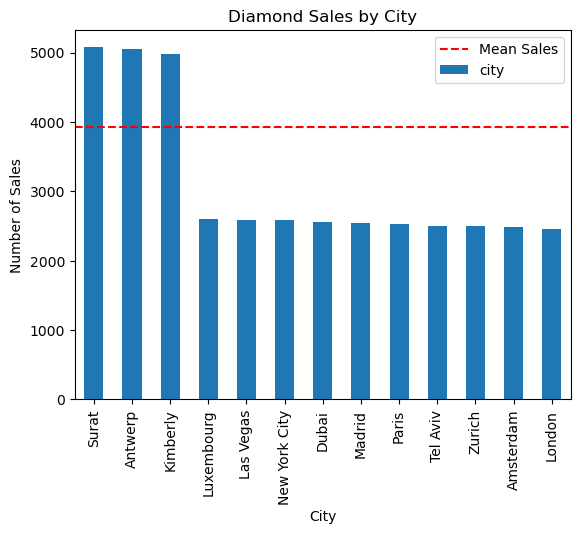

In [12]:
city_counts = diamonds_df['city'].value_counts()
mean_price = diamonds_df['price'].mean()

ax = city_counts.plot(kind='bar')
ax.axhline(mean_price, color='r', linestyle='--', label='Mean Sales')
plt.xlabel('City')
plt.ylabel('Number of Sales')
plt.title('Diamond Sales by City')
plt.legend()
plt.show()

In [15]:
price_city = diamonds_df.groupby(by="city",as_index=False).agg({'price': 'mean'}).sort_values(by='price')
price_city

,city,price
11,Tel Aviv,3753.746507
1,Antwerp,3842.225679
6,Luxembourg,3853.282809
9,Paris,3906.252569
4,Las Vegas,3919.199536
8,New York City,3927.937355
5,London,3952.769387
10,Surat,3966.823379
7,Madrid,3977.653937
3,Kimberly,3980.353095


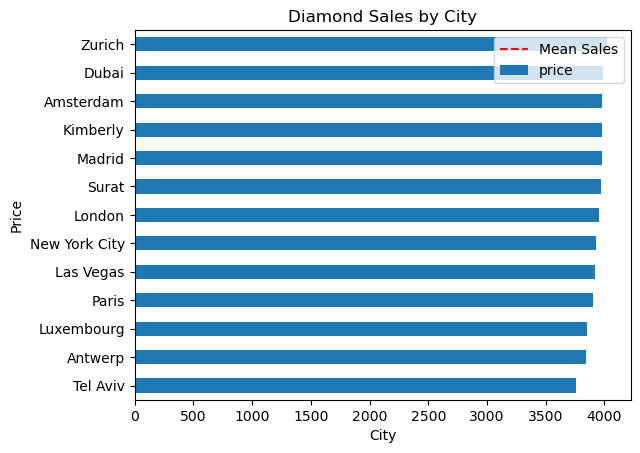

In [51]:
price_city = diamonds_df.groupby('city', as_index=False)['price'].mean().set_index('city').sort_values(by='price', ascending=True)
city_mean = diamonds_df['price'].mean()

ax = price_city.plot(kind='barh')
ax.axhline(city_mean, color='r', linestyle='--', label='Mean Sales')
plt.xlabel('City')
plt.ylabel('Price')
plt.title('Diamond Sales by City')
plt.legend()
plt.show()

In [17]:
city_sales = diamonds_df.groupby(by="city",as_index=False).agg({'price': 'count'}).sort_values(by='price')
city_sales

,city,price
5,London,2463
0,Amsterdam,2485
12,Zurich,2497
11,Tel Aviv,2505
9,Paris,2530
7,Madrid,2540
2,Dubai,2561
4,Las Vegas,2586
8,New York City,2586
6,Luxembourg,2606


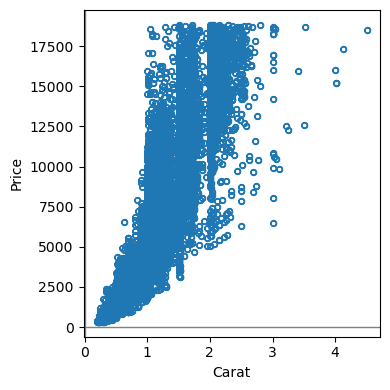

In [22]:
ax = diamonds_df.plot.scatter(x='carat',
                          y='price',
                          figsize=(4, 4),
                          marker='$\u25EF$',
                          alpha=1)
ax.set_xlabel('Carat')
ax.set_ylabel('Price')
ax.axhline(0, color='grey', lw=1)
ax.axvline(0, color='grey', lw=1)
##plt.xlim([-2, 2])
##plt.ylim([-2, 2])
plt.tight_layout()

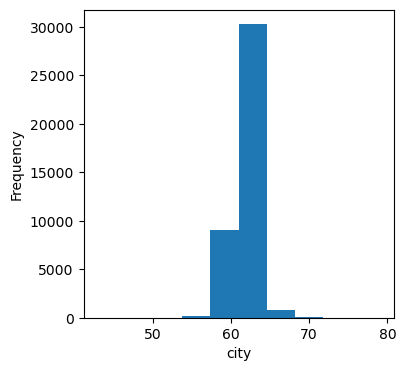

In [19]:
ax = diamonds_df['depth'].plot.hist(
                    figsize=(4, 4))
ax.set_xlabel('city')
plt.show()

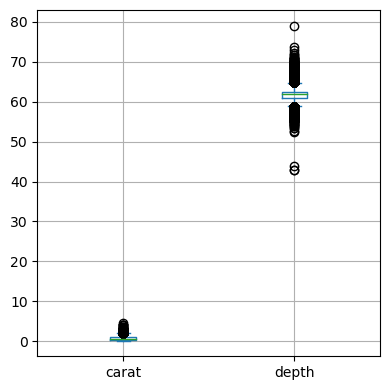

In [23]:
ax = diamonds_df[['carat','depth']].plot.box(figsize=(4, 4))
#ax.boxplot(data, whis=[0, 100])
plt.tight_layout()
plt.grid()
plt.show()

/var/folders/19/xp05rklx1dsfj3fpvkq0qry00000gn/T/ipykernel_1073/2092892866.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  ax = sns.heatmap(diamonds_df.corr(),


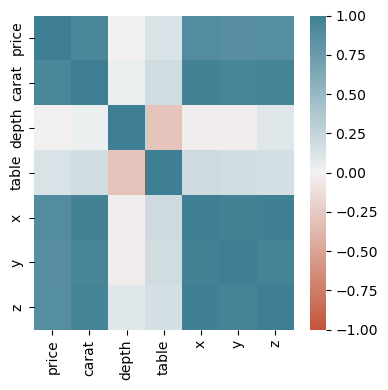

In [21]:
fig, ax = plt.subplots(figsize=(4, 4))
ax = sns.heatmap(diamonds_df.corr(),
                 vmin=-1,
                 vmax=1,
                 cmap=sns.diverging_palette(20, 220, as_cmap=True),
                 # https://seaborn.pydata.org/generated/seaborn.diverging_palette.html
                 ax=ax)
plt.tight_layout()